In [1]:
# Imports
import tensorflow as tf 
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [2]:
# Obtain CelebA faces dataset
!mkdir celebFaces
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celebFaces/data.zip

Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/celebFaces/data.zip
100% 1.44G/1.44G [00:06<00:00, 218MB/s]


In [3]:
# Unzip 
!unzip -qq celebFaces/data.zip -d celebFaces

In [4]:
# batch size for image batches
batch_size = 32

# Extract images as 64x64 to dataset
dataset_images = keras.preprocessing.image_dataset_from_directory('celebFaces', batch_size=batch_size,
                                                           label_mode=None, image_size=(64, 64))

Found 202599 files belonging to 1 classes.


In [5]:
# Normalize pixel values
dataset_images = dataset_images.map(lambda x: x / 255.)

In [6]:
# Latent dimensions
latent_dim = 64

# sampling function to obtain sample for encoder distribution (reparametrization)
def sampling(args):
  mean, var = args
  # define epsilon as a sample from Gaussian prior
  epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean), mean=0., stddev=1.) 
  # mean + epsilon*sigma
  return mean + keras.backend.exp(var/2)*epsilon   
    
## Encoder

# set input shape to imagesize
encoderInput =  keras.Input(shape=(64, 64, 3))

# Define Convolutional layers with leaky ReLU
x = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(encoderInput)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.2)(x)

# Save preflatten shape to use in decoder
preFlattenShape = keras.backend.int_shape(x)[1:]
    
# flatten layer to extract mean and var
x = keras.layers.Flatten()(x)
    
# define mean and sigma (they're the same now, but are learned independently)
mean = keras.layers.Dense(latent_dim, name = 'mean')(x)
var = keras.layers.Dense(latent_dim, name = 'var')(x)

# output by sampling mean and var from Gaussian prior
encoderOutput = keras.layers.Lambda(sampling, name='encoderOutput')([mean, var])

# define encoder explicitly as model
encoder = keras.Model(encoderInput, [mean, var, encoderOutput], name='Encoder')

## Decoder

# take latent vector z as input
decoderInput = keras.Input(shape = (latent_dim,))
  
# add dense layer using preFlattenShape to get correct dimensions of result image
x = keras.layers.Dense(np.prod(preFlattenShape))(decoderInput)
x = keras.layers.Reshape(preFlattenShape)(x)

# Upscale using transpose convolutional layers
x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x)
    
# define output and model
decoderOutput = x
decoder = keras.Model(decoderInput, decoderOutput, name='Decoder')

In [7]:
# class VAE puts the encoder and decoder together, overrides the train_step method and tracks the KL-loss
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE,self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    
    self.totalLossTracker = keras.metrics.Mean(name="totalLoss")
    self.reconstructionLossTracker = keras.metrics.Mean(name="reconstructionLoss")
    self.KLlossTracker = keras.metrics.Mean(name="KLloss")

  # loss metric trackers
  @property
  def metrics(self):
    return [self.totalLossTracker, self.reconstructionLossTracker, self.KLlossTracker]

  # overwrite train_step
  def train_step(self, data):
    with tf.GradientTape() as tape:
      # get samples 
      mean, var, z = self.encoder(data)
      # reconstruct image from samples
      reconstruct = self.decoder(z)
      # get reconstruction loss
      reconstructionLoss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruct), axis=(1, 2)))

      # compute KL-loss/divergence
      KLloss = -0.5 * (1 + var - tf.square(mean) - tf.exp(var))
      KLloss = tf.reduce_mean(tf.reduce_sum(KLloss, axis=1))

      # get total loss by summing KL-loss and reconstruction loss
      totalLoss = reconstructionLoss + KLloss

      # obtain and apply gradients to VAE to train it
      grads = tape.gradient(totalLoss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      # update losses
      self.totalLossTracker.update_state(totalLoss)
      self.reconstructionLossTracker.update_state(reconstructionLoss)
      self.KLlossTracker.update_state(KLloss)
      
      # return all 3 losses
      return {
        "totalLoss": self.totalLossTracker.result(),
        "reconstructionLoss": self.reconstructionLossTracker.result(),
        "KLloss": self.KLlossTracker.result(),
      }

# custom callback method to print images on epoch end
class customCallback(keras.callbacks.Callback):
  def __init__(self, num_images):
    self.num_images = num_images

  # override on_epoch_end to display images after each epoch is done training
  def on_epoch_end(self, epoch, logs=None):
    # get random batch from latent space and decode it (generating new images)
    reconstructed = decoder.predict(np.random.normal(0,1,size=(self.num_images,latent_dim)))

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(self.num_images):
      image = keras.preprocessing.image.array_to_img(reconstructed[i])
      plt.subplot(2, 5, i+1)
      plt.imshow(reconstructed[i])
      plt.xticks([])  
      plt.yticks([]) 
    plt.tight_layout()
    plt.show()

Epoch 1/30
6332/6332 [==============================] - ETA: 0s - totalLoss: 2169.0969 - reconstructionLoss: 2112.1270 - KLloss: 56.9669

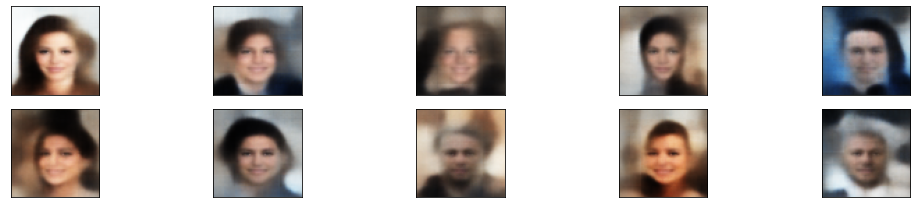

6332/6332 [==============================] - 78s 11ms/step - totalLoss: 2169.0969 - reconstructionLoss: 2112.1270 - KLloss: 56.9669
Epoch 2/30
6327/6332 [============================>.] - ETA: 0s - totalLoss: 2142.4211 - reconstructionLoss: 2082.1240 - KLloss: 60.3007

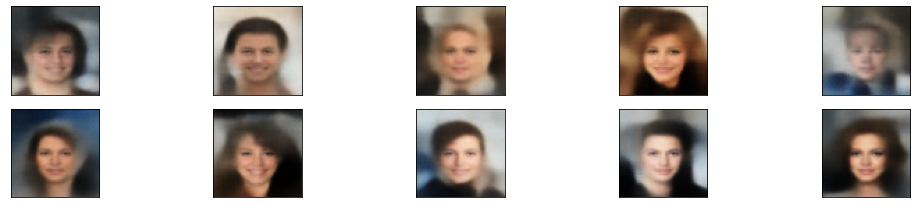

6332/6332 [==============================] - 67s 11ms/step - totalLoss: 2142.4348 - reconstructionLoss: 2082.1370 - KLloss: 60.3014
Epoch 3/30
6328/6332 [============================>.] - ETA: 0s - totalLoss: 2138.9148 - reconstructionLoss: 2078.7329 - KLloss: 60.1773

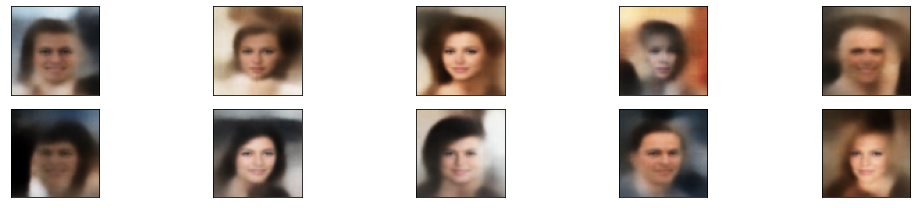

6332/6332 [==============================] - 69s 11ms/step - totalLoss: 2138.9172 - reconstructionLoss: 2078.7349 - KLloss: 60.1780
Epoch 4/30
6332/6332 [==============================] - ETA: 0s - totalLoss: 2137.0969 - reconstructionLoss: 2077.0498 - KLloss: 60.0486

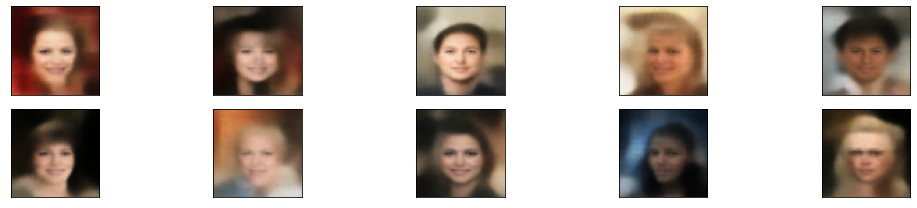

6332/6332 [==============================] - 66s 10ms/step - totalLoss: 2137.0969 - reconstructionLoss: 2077.0498 - KLloss: 60.0486
Epoch 5/30
6325/6332 [============================>.] - ETA: 0s - totalLoss: 2135.5520 - reconstructionLoss: 2075.3306 - KLloss: 60.2171

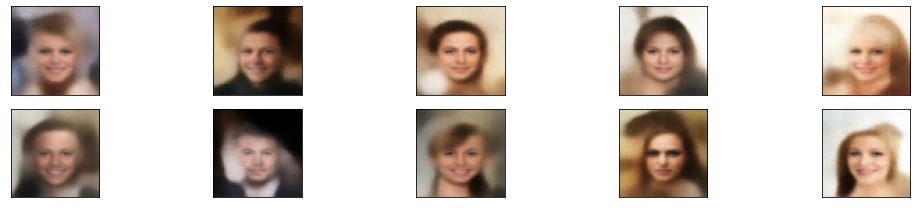

6332/6332 [==============================] - 64s 10ms/step - totalLoss: 2135.5122 - reconstructionLoss: 2075.2910 - KLloss: 60.2167
Epoch 6/30
6328/6332 [============================>.] - ETA: 0s - totalLoss: 2134.4065 - reconstructionLoss: 2074.1724 - KLloss: 60.2313

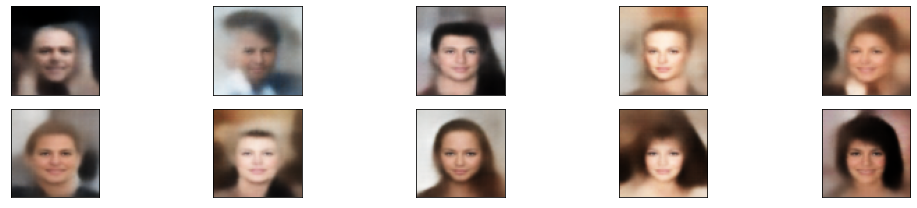

6332/6332 [==============================] - 64s 10ms/step - totalLoss: 2134.3982 - reconstructionLoss: 2074.1628 - KLloss: 60.2323
Epoch 7/30
6325/6332 [============================>.] - ETA: 0s - totalLoss: 2133.6997 - reconstructionLoss: 2073.5051 - KLloss: 60.1933

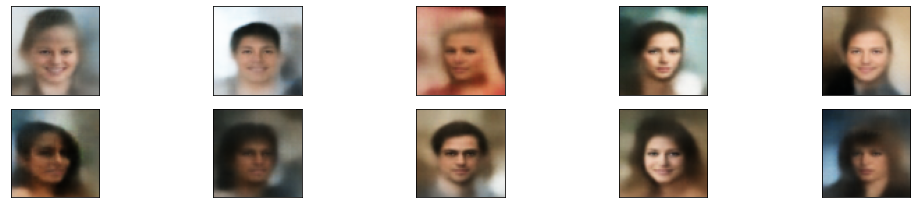

6332/6332 [==============================] - 65s 10ms/step - totalLoss: 2133.7202 - reconstructionLoss: 2073.5259 - KLloss: 60.1934
Epoch 8/30
6330/6332 [============================>.] - ETA: 0s - totalLoss: 2133.2324 - reconstructionLoss: 2073.0273 - KLloss: 60.2022

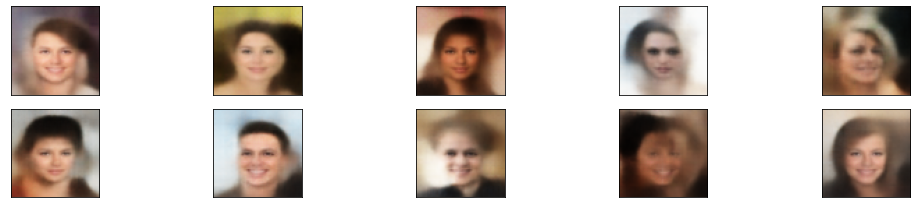

6332/6332 [==============================] - 66s 10ms/step - totalLoss: 2133.2222 - reconstructionLoss: 2073.0176 - KLloss: 60.2016
Epoch 9/30
6330/6332 [============================>.] - ETA: 0s - totalLoss: 2132.8074 - reconstructionLoss: 2072.6384 - KLloss: 60.1677

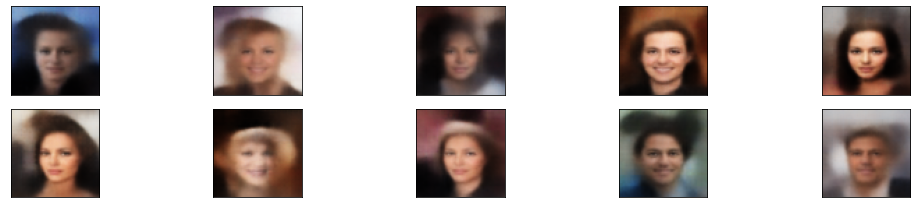

6332/6332 [==============================] - 66s 10ms/step - totalLoss: 2132.7651 - reconstructionLoss: 2072.5957 - KLloss: 60.1681
Epoch 10/30
6326/6332 [============================>.] - ETA: 0s - totalLoss: 2132.4312 - reconstructionLoss: 2072.2844 - KLloss: 60.1463

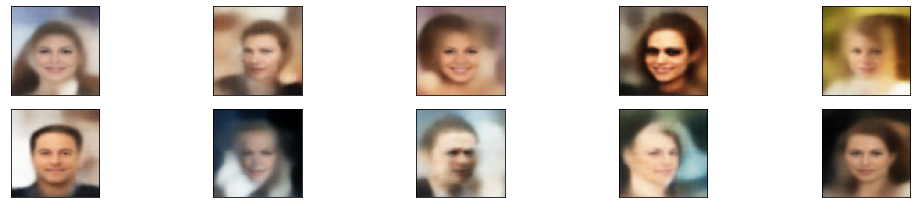

6332/6332 [==============================] - 66s 10ms/step - totalLoss: 2132.4507 - reconstructionLoss: 2072.3047 - KLloss: 60.1454
Epoch 11/30
6327/6332 [============================>.] - ETA: 0s - totalLoss: 2132.1133 - reconstructionLoss: 2071.9961 - KLloss: 60.1180

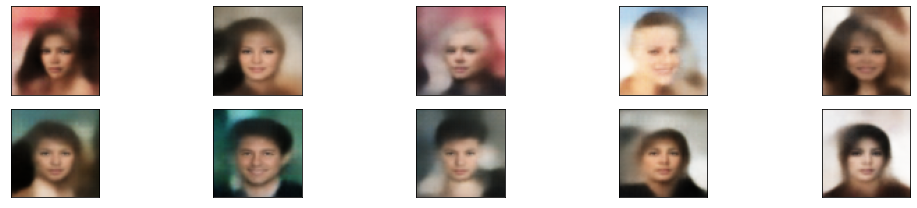

6332/6332 [==============================] - 68s 11ms/step - totalLoss: 2132.1487 - reconstructionLoss: 2072.0320 - KLloss: 60.1175
Epoch 12/30
6329/6332 [============================>.] - ETA: 0s - totalLoss: 2131.9600 - reconstructionLoss: 2071.8376 - KLloss: 60.1213

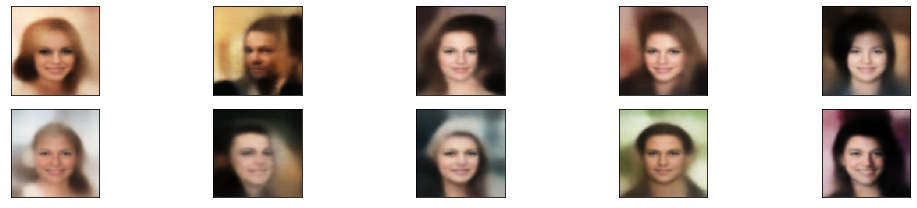

6332/6332 [==============================] - 67s 11ms/step - totalLoss: 2131.9099 - reconstructionLoss: 2071.7874 - KLloss: 60.1218
Epoch 13/30
6332/6332 [==============================] - ETA: 0s - totalLoss: 2131.7366 - reconstructionLoss: 2071.6167 - KLloss: 60.1180

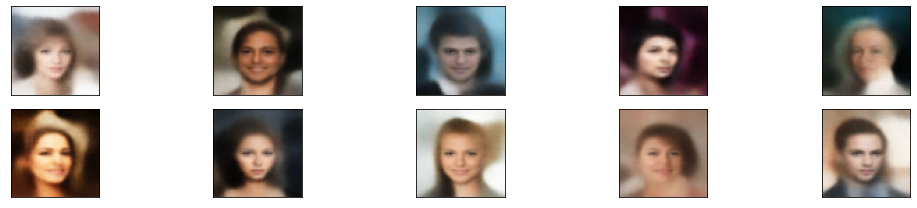

6332/6332 [==============================] - 68s 11ms/step - totalLoss: 2131.7366 - reconstructionLoss: 2071.6167 - KLloss: 60.1180
Epoch 14/30
6331/6332 [============================>.] - ETA: 0s - totalLoss: 2131.5381 - reconstructionLoss: 2071.4399 - KLloss: 60.0961

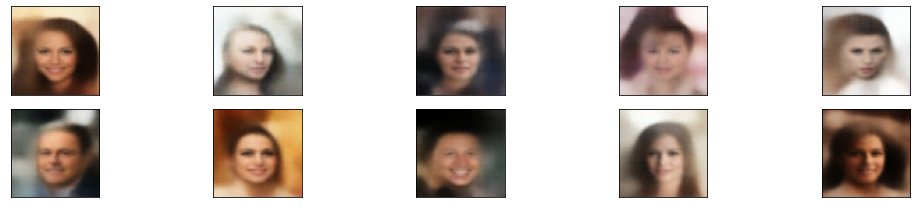

6332/6332 [==============================] - 69s 11ms/step - totalLoss: 2131.5454 - reconstructionLoss: 2071.4470 - KLloss: 60.0965
Epoch 15/30
6325/6332 [============================>.] - ETA: 0s - totalLoss: 2131.4014 - reconstructionLoss: 2071.3188 - KLloss: 60.0824

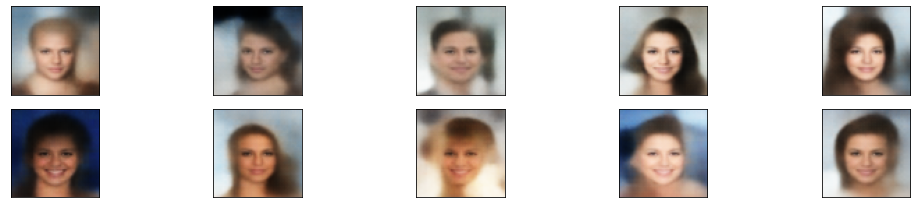

6332/6332 [==============================] - 69s 11ms/step - totalLoss: 2131.3750 - reconstructionLoss: 2071.2905 - KLloss: 60.0840
Epoch 16/30
6329/6332 [============================>.] - ETA: 0s - totalLoss: 2131.2048 - reconstructionLoss: 2071.1384 - KLloss: 60.0654

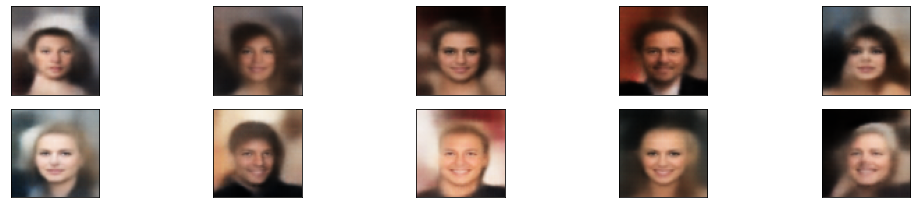

6332/6332 [==============================] - 69s 11ms/step - totalLoss: 2131.2136 - reconstructionLoss: 2071.1482 - KLloss: 60.0643
Epoch 17/30
6326/6332 [============================>.] - ETA: 0s - totalLoss: 2131.0498 - reconstructionLoss: 2070.9927 - KLloss: 60.0576

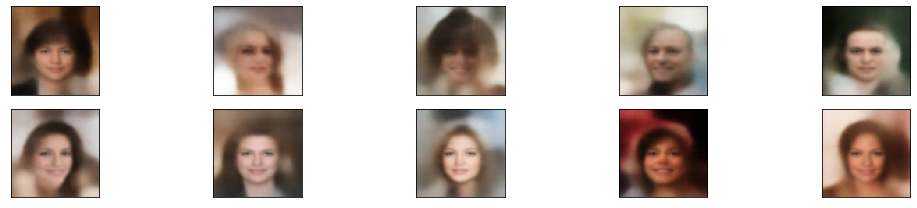

6332/6332 [==============================] - 70s 11ms/step - totalLoss: 2131.0483 - reconstructionLoss: 2070.9934 - KLloss: 60.0554
Epoch 18/30
6330/6332 [============================>.] - ETA: 0s - totalLoss: 2130.9927 - reconstructionLoss: 2070.9236 - KLloss: 60.0727

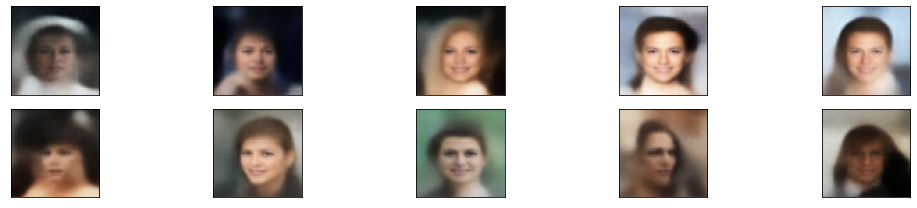

6332/6332 [==============================] - 71s 11ms/step - totalLoss: 2130.9897 - reconstructionLoss: 2070.9211 - KLloss: 60.0721
Epoch 19/30
6331/6332 [============================>.] - ETA: 0s - totalLoss: 2130.8333 - reconstructionLoss: 2070.7905 - KLloss: 60.0487

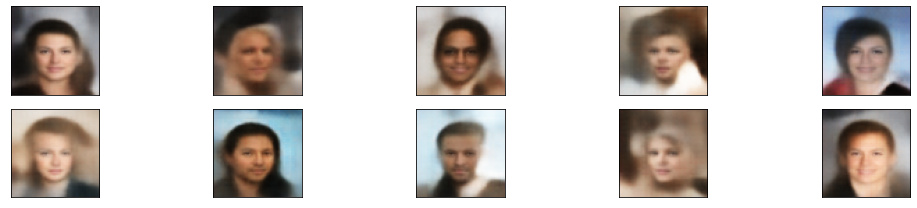

6332/6332 [==============================] - 71s 11ms/step - totalLoss: 2130.8362 - reconstructionLoss: 2070.7939 - KLloss: 60.0481
Epoch 20/30
6329/6332 [============================>.] - ETA: 0s - totalLoss: 2130.7971 - reconstructionLoss: 2070.7280 - KLloss: 60.0695

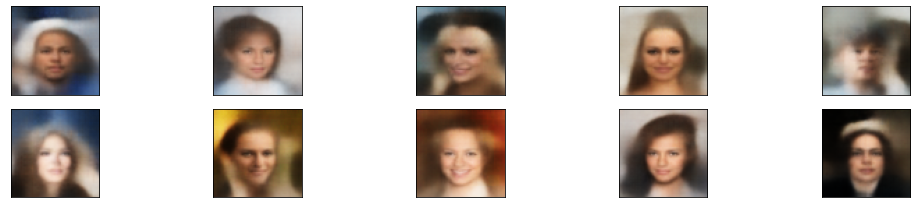

6332/6332 [==============================] - 72s 11ms/step - totalLoss: 2130.7710 - reconstructionLoss: 2070.7009 - KLloss: 60.0702
Epoch 21/30
6330/6332 [============================>.] - ETA: 0s - totalLoss: 2130.7034 - reconstructionLoss: 2070.6318 - KLloss: 60.0682

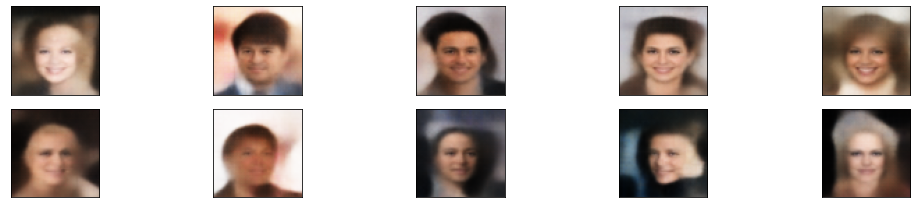

6332/6332 [==============================] - 72s 11ms/step - totalLoss: 2130.6931 - reconstructionLoss: 2070.6216 - KLloss: 60.0681
Epoch 22/30
6326/6332 [============================>.] - ETA: 0s - totalLoss: 2130.5693 - reconstructionLoss: 2070.5110 - KLloss: 60.0594

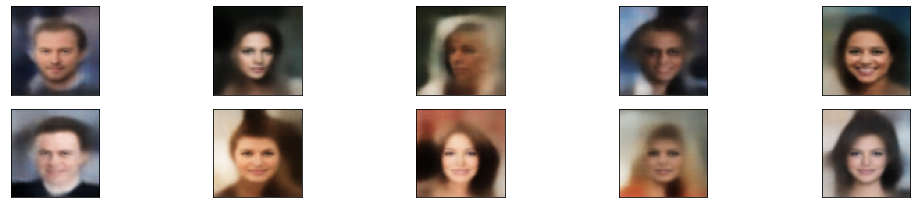

6332/6332 [==============================] - 73s 12ms/step - totalLoss: 2130.5918 - reconstructionLoss: 2070.5354 - KLloss: 60.0577
Epoch 23/30
6325/6332 [============================>.] - ETA: 0s - totalLoss: 2130.5112 - reconstructionLoss: 2070.4548 - KLloss: 60.0570

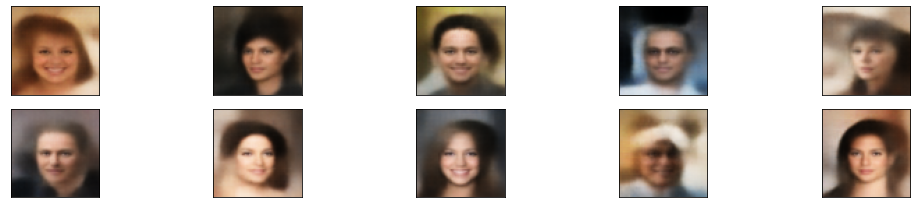

6332/6332 [==============================] - 73s 11ms/step - totalLoss: 2130.5356 - reconstructionLoss: 2070.4778 - KLloss: 60.0584
Epoch 24/30
6325/6332 [============================>.] - ETA: 0s - totalLoss: 2130.4175 - reconstructionLoss: 2070.4021 - KLloss: 60.0133

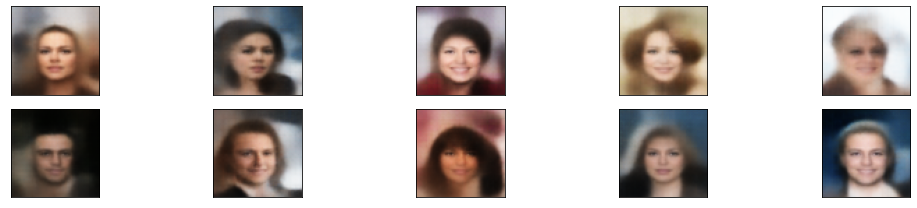

6332/6332 [==============================] - 73s 12ms/step - totalLoss: 2130.4302 - reconstructionLoss: 2070.4153 - KLloss: 60.0130
Epoch 25/30
6327/6332 [============================>.] - ETA: 0s - totalLoss: 2130.3613 - reconstructionLoss: 2070.3176 - KLloss: 60.0428

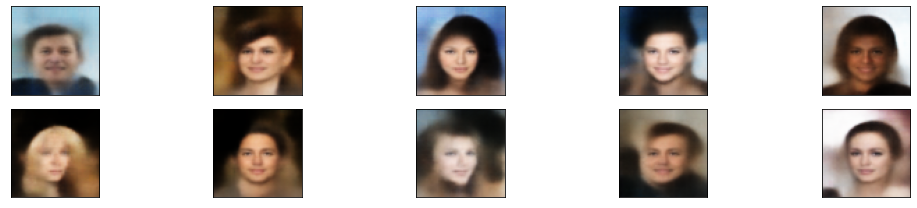

6332/6332 [==============================] - 73s 12ms/step - totalLoss: 2130.3557 - reconstructionLoss: 2070.3137 - KLloss: 60.0411
Epoch 26/30
6326/6332 [============================>.] - ETA: 0s - totalLoss: 2130.3677 - reconstructionLoss: 2070.3303 - KLloss: 60.0418

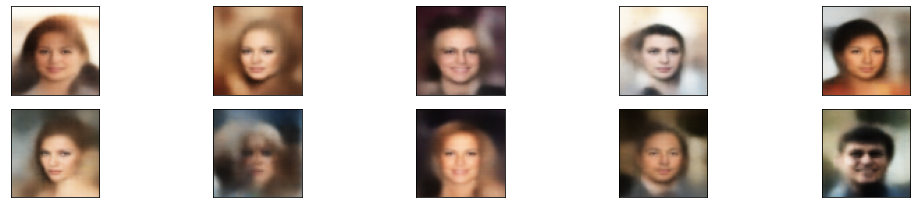

6332/6332 [==============================] - 74s 12ms/step - totalLoss: 2130.3142 - reconstructionLoss: 2070.2749 - KLloss: 60.0437
Epoch 27/30
6331/6332 [============================>.] - ETA: 0s - totalLoss: 2130.2361 - reconstructionLoss: 2070.1868 - KLloss: 60.0480

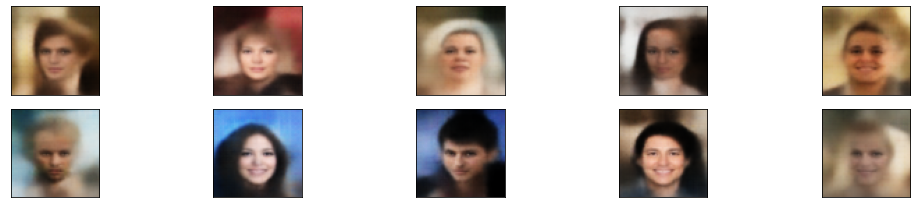

6332/6332 [==============================] - 74s 12ms/step - totalLoss: 2130.2380 - reconstructionLoss: 2070.1880 - KLloss: 60.0485
Epoch 28/30
6326/6332 [============================>.] - ETA: 0s - totalLoss: 2130.1909 - reconstructionLoss: 2070.1250 - KLloss: 60.0635

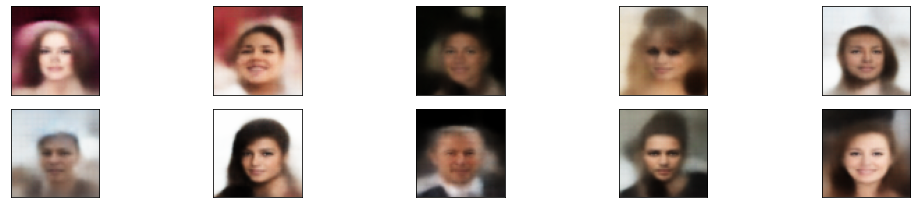

6332/6332 [==============================] - 75s 12ms/step - totalLoss: 2130.2117 - reconstructionLoss: 2070.1462 - KLloss: 60.0629
Epoch 29/30
6329/6332 [============================>.] - ETA: 0s - totalLoss: 2130.1245 - reconstructionLoss: 2070.0896 - KLloss: 60.0401

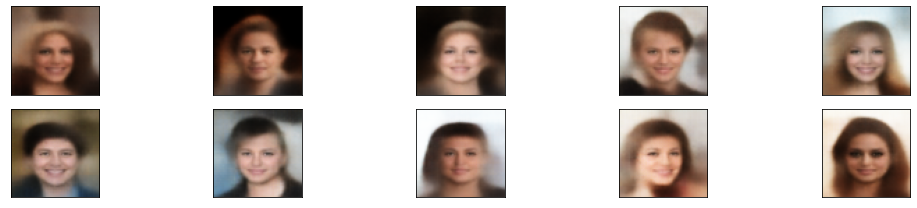

6332/6332 [==============================] - 76s 12ms/step - totalLoss: 2130.1094 - reconstructionLoss: 2070.0735 - KLloss: 60.0412
Epoch 30/30
6328/6332 [============================>.] - ETA: 0s - totalLoss: 2130.0527 - reconstructionLoss: 2070.0190 - KLloss: 60.0408

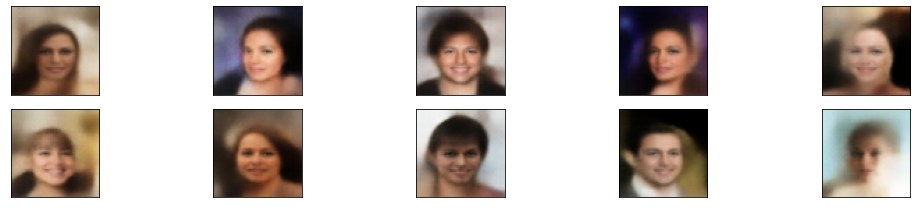

6332/6332 [==============================] - 79s 12ms/step - totalLoss: 2130.0623 - reconstructionLoss: 2070.0286 - KLloss: 60.0408


In [8]:
# compile VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(dataset_images, epochs=30, callbacks=[customCallback(num_images=10)])

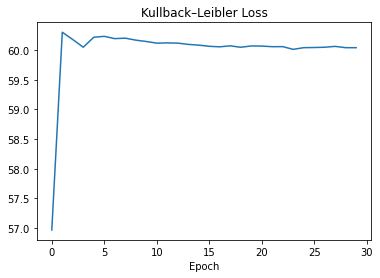

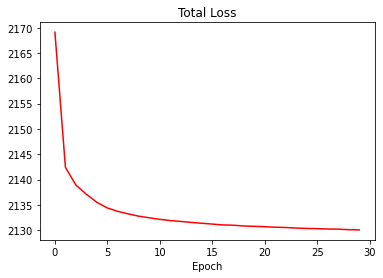

In [9]:
# Get losses from each epoch 
totalLoss = (history.history)['totalLoss']
reconstructionLoss = (history.history)['reconstructionLoss']
KLloss = (history.history)['KLloss']

#plt.plot(totalLoss, label='totalLoss', color='blue')
#plt.plot(reconstructionLoss, label='reconstructionLoss', color='red')
plt.plot(KLloss, label='KLloss')
plt.xlabel('Epoch')
plt.title('Kullback–Leibler Loss')
plt.show()

plt.plot(totalLoss, label='totalLoss', color='red')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.show()

In [11]:
# Generate some images before training
def vae_generate(num_images=10):
  reconstructed = decoder.predict(np.random.normal(0,1,size=(num_images,latent_dim)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(num_images):
    image = keras.preprocessing.image.array_to_img(reconstructed[i])
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructed[i])
    plt.xticks([])  
    plt.yticks([]) 
  plt.tight_layout()
  plt.show() 
  return reconstructed

In [10]:
## Evaluating image quality w/ FID 

# define model
inception = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 0s 0us/step


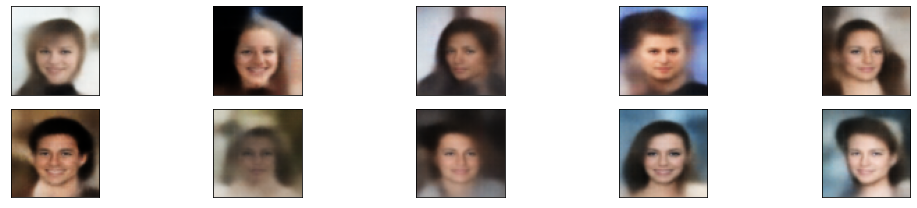

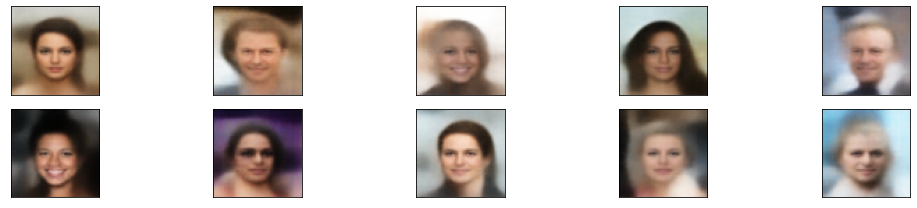

FID (generated vs generated): 0.096
FID (generated vs real): 3.030


In [14]:
from skimage.transform import resize
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import preprocess_input

# upscale image to new_shape
def upscale(images, new_shape):
	result = list()
	for image in images:
		# resize 
		upscaled = resize(image, new_shape, 0)
		# store
		result.append(upscaled)
	return np.asarray(result)
 
def getFID(model, img1, img2):
  # let the DCGAN run on two images
	activation1 = model.predict(img1)
	activation2 = model.predict(img2)
 
	# calculate mean and covariance 
	mean1, cov1 = activation1.mean(axis=0), np.cov(activation1, rowvar=False)
	mean2, cov2 = activation2.mean(axis=0), np.cov(activation2, rowvar=False)
 
	# get mean squared difference 
	meanDiff = np.sum((mean1 - mean2)**2.0)
 
	# calculate sqrt of product between cov
	sigmaMean = sqrtm(cov1.dot(cov2))
 
	if np.iscomplexobj(sigmaMean):
		sigmaMean = sigmaMean.real
	# calculate score
	FID = meanDiff + np.trace(cov1 + cov2 - 2.0 * sigmaMean)
	return FID

# define collections of 10 fake images
fakeSet1 = vae_generate()
fakeSet2 = vae_generate()

# preprocess sets
fakeSet1 = fakeSet1.astype('float32')
fakeSet2 = fakeSet2.astype('float32')

fakeSet1 = upscale(fakeSet1, (299,299,3))
fakeSet2 = upscale(fakeSet2, (299,299,3))

fakeSet1 = preprocess_input(fakeSet1)
fakeSet2 = preprocess_input(fakeSet2)

# FID between two sets of generated images
fid = getFID(inception, fakeSet1, fakeSet2)
print('FID (generated vs generated): %.3f' % fid)

fakeSet3 = np.zeros((10,64,64,3))
# get 10 real images
counter = 0
for batch in dataset_images:
  if(counter >=9):
    break;
  rand = np.random.randint(0, 32)
  fakeSet3[counter] = batch[rand]
  counter+=1

# preprocessing
fakeSet3 = fakeSet3.astype('float32')
fakeSet3 = upscale(fakeSet3, (299,299,3))
fakeSet3 = preprocess_input(fakeSet3)

# FID between generated and real images
fid = getFID(inception, fakeSet1, fakeSet3)
print('FID (generated vs real): %.3f' % fid)